In [1]:
#libraries 
import matplotlib.pyplot as plt 
from matplotlib.image import imread
import random
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras import Model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

In [2]:
#import images

cat_folder = 'C:/Users/Claire R/Downloads/AdvancedDS/catdog_app/data/PetImages/Cat'
dog_folder = 'C:/Users/Claire R/Downloads/AdvancedDS/catdog_app/data/PetImages/Dog'

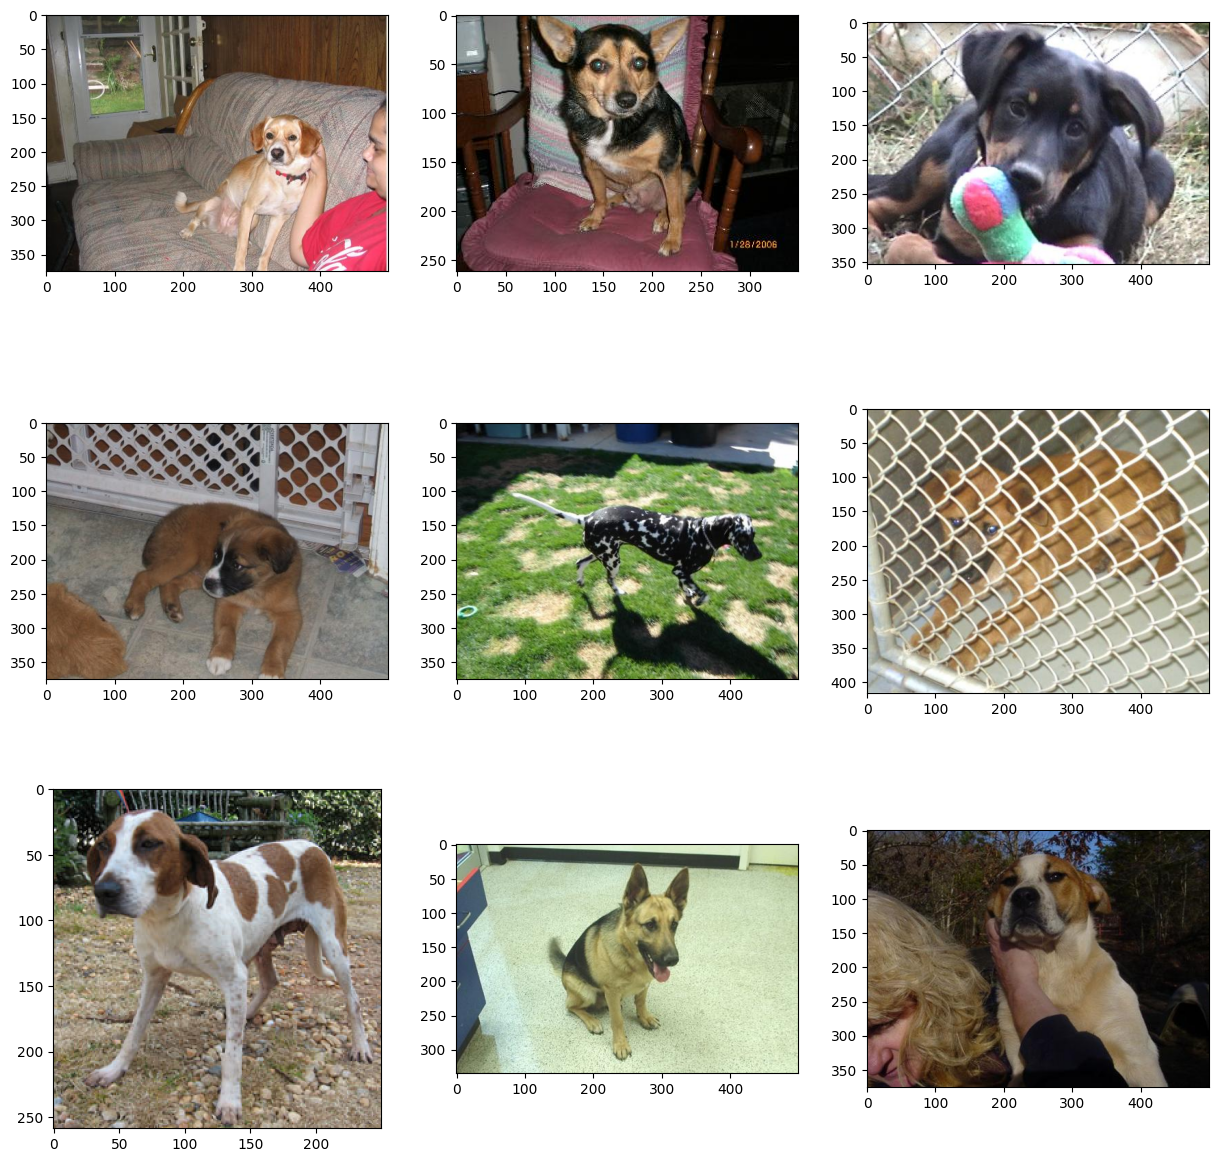

In [3]:
#random file inspection for dogs

plt.figure(figsize=(15,15))


for i in range(9):
    plt.subplot(330+1+i)
    sample = random.randint(0,12498)
    filename = os.path.join(dog_folder, str(sample) + ".jpg") 
    image = imread(filename)
    plt.imshow(image)
    
plt.show()

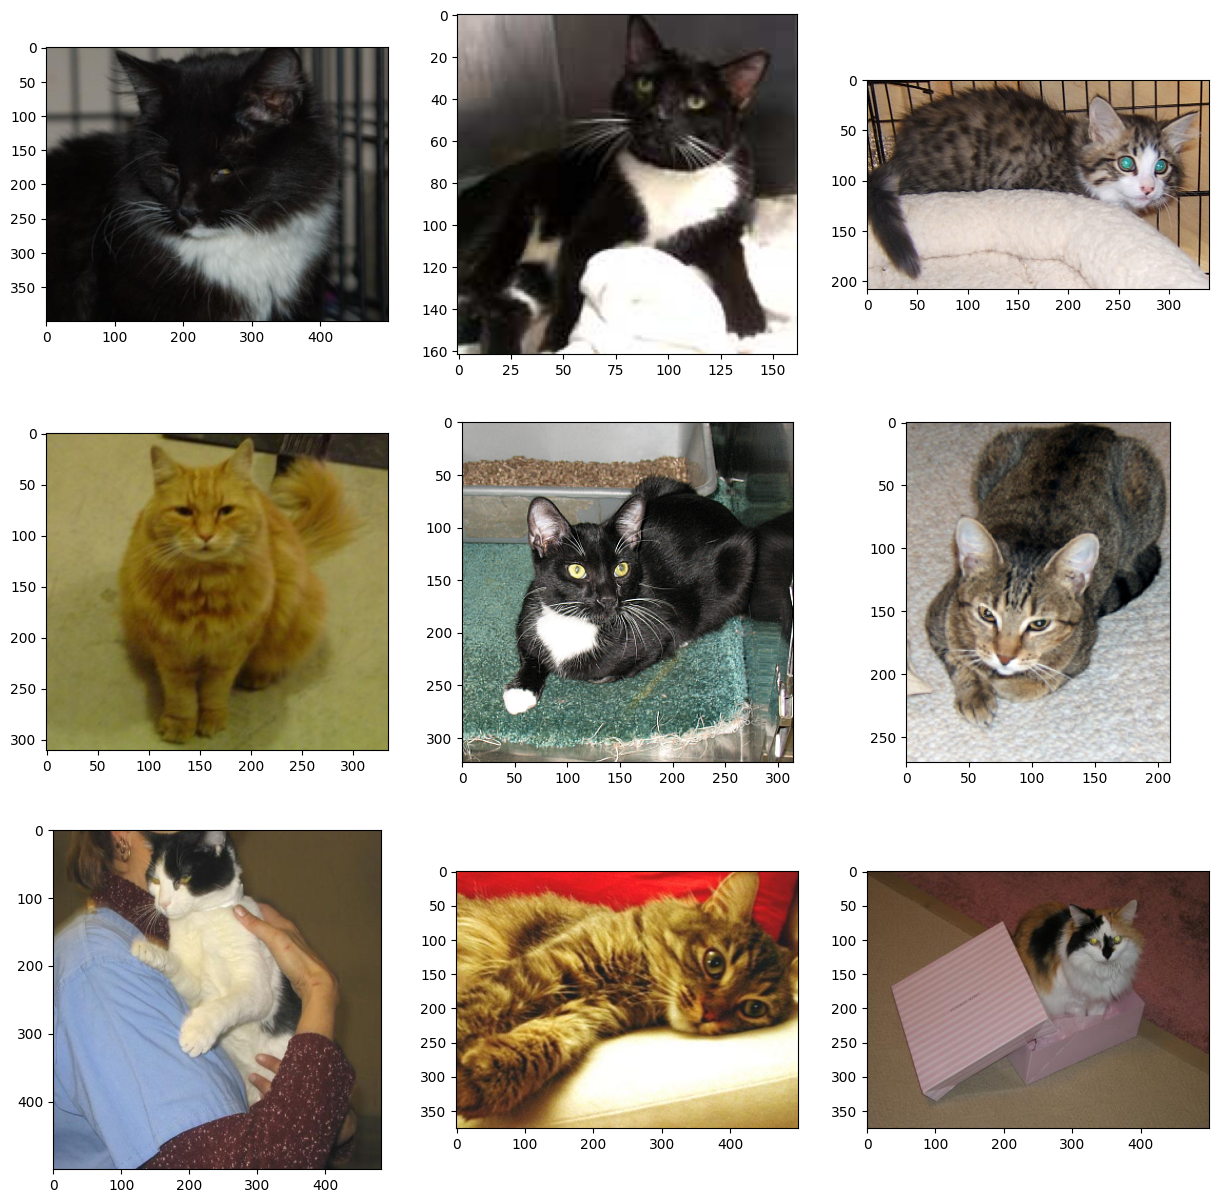

In [4]:
#random file inspection for cats

plt.figure(figsize=(15,15))


for i in range(9):
    plt.subplot(330+1+i)
    sample = random.randint(0,12498)
    filename = os.path.join(cat_folder, str(sample) + ".jpg") 
    image = imread(filename)
    plt.imshow(image)
    
plt.show()

In [5]:
#define function to add labels to data

features = []
labels = []

def preprocessing(folder, label):
    files = os.listdir(folder)
    for file in files:
        image = cv2.imread(folder + file)
        if image is not None:
            image = cv2.resize(image, dsize = (128, 128))
            features.append(image)
            labels.append(label)
            
            
preprocessing(cat_folder + '/', 0)
preprocessing(dog_folder + '/', 1)

In [6]:
#send labels to csv for EDA
df = pd.DataFrame(labels, columns=["labels"])

csv_file_path = 'labels.csv'

df.to_csv(csv_file_path, index=False)

In [7]:
#change the features+labels to arrays for easier manipulation
features_array = np.array(features).astype(np.float32)
labels_array = np.array(labels).astype(np.float32)

In [8]:
features_array.shape

(24913, 128, 128, 3)

In [9]:
labels_array.shape

(24913,)

In [10]:
features[698].dtype

dtype('uint8')

In [11]:
#normalize the data by dividing the pixel arrays by 255
#Common technique when dealing with images in Red,Green,Blue color space
#Range in color intensity from 0-255

normalized = features_array / 255

#Now the pixel color values have been normalized so they are between 0-1
#mutes the colors by A LOT

Text(0.5, 1.0, "It's a Cat!!!")

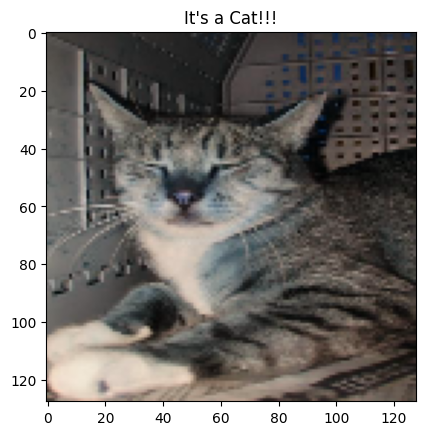

In [12]:
#BLUE CATS AND DOGS!!!

sample = random.randint(0,len(normalized))

image = normalized[sample]
label = labels_array[sample]

if label == 0:
    title = "It's a Cat!!!"
elif label == 1:
    title = "It's a Dog!!!"

image.shape
plt.imshow(image)
plt.title(title)

In [13]:
train_x, test_X, train_y, test_Y = train_test_split(normalized, labels_array, test_size=0.2, shuffle=True)

In [14]:
print(len(train_x))
print(len(test_X))

19930
4983


In [15]:
np.unique(train_y, return_counts=True)

(array([0., 1.], dtype=float32), array([9996, 9934], dtype=int64))

In [16]:
train_labels_onehot = to_categorical(train_y)
test_labels_onehot = to_categorical(test_Y)

In [17]:
print(train_y[3])
print(train_labels_onehot[3])

0.0
[1. 0.]


In [18]:
print(len(test_X), len(test_labels_onehot))

print(test_labels_onehot.shape)

print(test_labels_onehot[500])

print(test_labels_onehot.ndim)



4983 4983
(4983, 2)
[1. 0.]
2


[0. 1.]


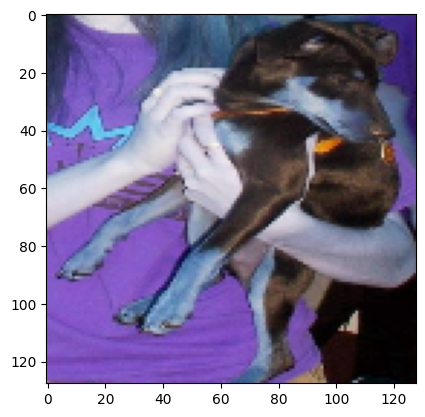

In [19]:
sample = random.randint(0,len(test_X))

image = test_X[sample]
label = test_labels_onehot[sample]

print(label)


image.shape
plt.imshow(image)

#dog is [0. 1.]
# cat is [1. 0.]

# Model Building

In [20]:
def cnn_alex(input_shape, num_classes):
    tf.random.set_seed(42)
    model = Sequential()
    
#     model.add(Input(input_shape = (128, 128, 3))),
    model.add(Conv2D(96, input_shape = input_shape, kernel_size=(11,11), strides=(4,4), activation = 'relu')),
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (3,3), strides =(2,2))),
    model.add(Conv2D(256, kernel_size=(5,5), padding='same', activation = 'relu')),
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (3,3), strides=(2,2))),
    
    model.add(Conv2D(384, kernel_size=(3,3),padding='same', activation = 'relu')),
    model.add(Conv2D(384, kernel_size=(3,3), padding='same', activation = 'relu')),
    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation = 'relu')),
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (3,3), strides=(2,2))),
    
    
    model.add(Flatten()),
    model.add(Dense(4096, activation = 'relu')),
    model.add(Dropout(rate = 0.5)),
    model.add(Dense(4096, activation = 'relu')),
    model.add(Dropout(rate = 0.5)),
    model.add(Dense(num_classes, activation = 'softmax'))
    
    model.compile(loss = 'binary_crossentropy',
                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                 metrics = ['accuracy'])
    return model

In [21]:
input_shape = train_x[0].shape
model_alex = cnn_alex(input_shape, 2)
model_alex.summary()
history_cnn_alex = model_alex.fit(train_x, train_labels_onehot, epochs =100, batch_size = 128)

c:\Users\Claire R\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,737,538 (94.37 MB)

 Trainable params: 24,736,322 (94.36 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 138s 827ms/step - accuracy: 0.5422 - loss: 1.4038
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 130s 828ms/step - accuracy: 0.6267 - loss: 0.6438
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 126s 806ms/step - accuracy: 0.6956 - loss: 0.5870
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 124s 792ms/step - accuracy: 0.7287 - loss: 0.5412
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 718ms/step - accuracy: 0.7697 - loss: 0.4887
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 719ms/step - accuracy: 0.7993 - loss: 0.4321
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 115s 737ms/step - accuracy: 0.8242 - loss: 0.3855
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 110s 705ms/step - accuracy: 0.8421 - loss: 0.3462
Epoch 9/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 112s 716ms/step - accuracy: 0.8652 - loss: 0.3031
Epoch 10/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 108s 693ms/step - accuracy: 0.8880 - loss: 0.2660
Epoch 11/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 110s 703ms/step - accuracy: 0.8971 - loss: 0.24

In [26]:
model_alex.evaluate(test_X, test_labels_onehot)

156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8406 - loss: 1.5003


[1.6078414916992188, 0.8458759784698486]

In [27]:
try:
    model_alex.save('model_alex.h5')
    print("Model saved")
except:
    print("Model could  not be saved")

Model saved


In [94]:
def random_prediction(features, model):
    index = np.random.randint(0, len(features))
    img = features[index]
    img =img.reshape( (1, 128, 128,3))
    prediction  = model(img)
    img = tf.squeeze(img)
    prediction =tf.squeeze(prediction)
    
    if(prediction[0]>prediction[1]):
        title = 'Cat'
    else:
        title  = 'Dog'
    plt.imshow(img)
    plt.title(title)

    print("Cat: " + str(prediction[0]))
    print("Dog: " + str(prediction[1]))

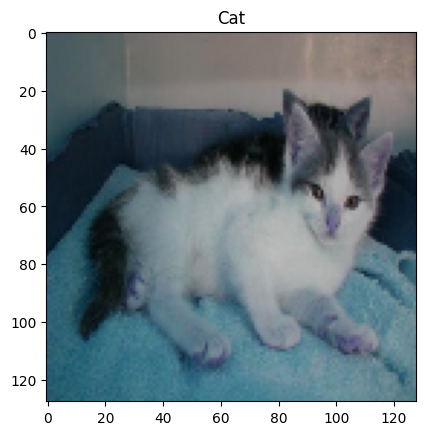

In [50]:
random_prediction(test_X, model_alex)

# Visualizing

In [88]:
model = load_model('C:/Users/Claire R/Downloads/model_alex.h5')

In [89]:
#death
plot_model(model)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [90]:
#pip install netron
#type netron into terminal and upload h5 file

In [91]:
#another possiblility it to use tensorboard but would have to retrain model :(

In [92]:
model.layers

[<Conv2D name=conv2d, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <Conv2D name=conv2d_3, built=True>,
 <Conv2D name=conv2d_4, built=True>,
 <BatchNormalization name=batch_normalization_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense_2, built=True>]

Cat: tf.Tensor(1.0, shape=(), dtype=float32)
Dog: tf.Tensor(2.5319626e-35, shape=(), dtype=float32)


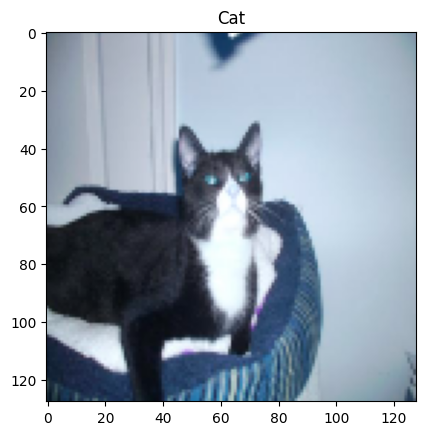

In [95]:
random_prediction(test_X, model)

In [96]:
#https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
#find out how to do feature maps


In [97]:
#conv layers
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

0 conv2d (None, 30, 30, 96)
3 conv2d_1 (None, 14, 14, 256)
6 conv2d_2 (None, 6, 6, 384)
7 conv2d_3 (None, 6, 6, 384)
8 conv2d_4 (None, 6, 6, 256)


In [98]:
model_test = Model(inputs=model.inputs, outputs=model.layers[1].output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


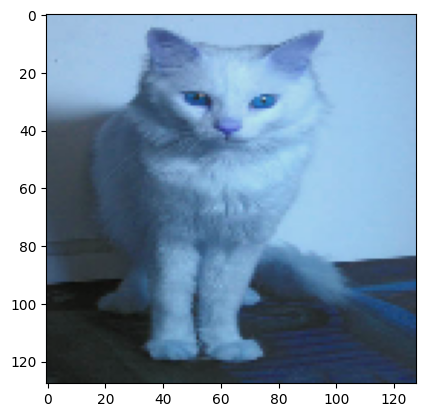

In [99]:
index = np.random.randint(0, len(features))
img = features[index]
img =img.reshape( (1, 128, 128,3))

feature_maps = model_test.predict(img)

img = tf.squeeze(img)
plt.imshow(img)

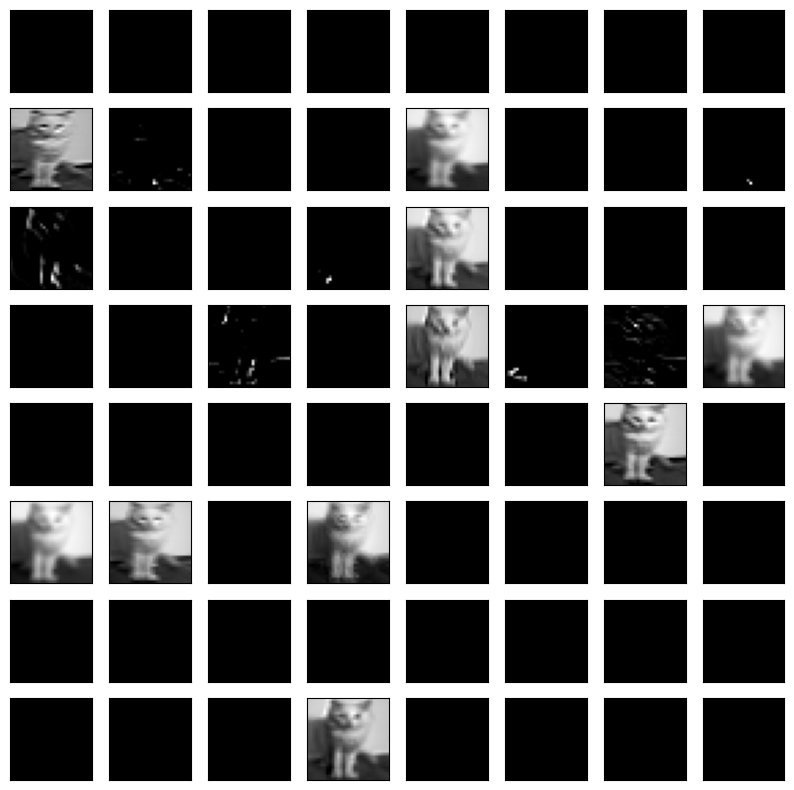

In [100]:
fig = plt.figure(figsize=(10, 10))
square = 8
ix = 1
for i in range(square):
	for j in range(square):
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
plt.show()

In [101]:
ixs = [0, 3, 6, 7, 8]
outputs = [model.layers[i+1].output for i in ixs]
model_testfull = Model(inputs=model.inputs, outputs=outputs)
model_testfull.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │     34,944 │ input_layer[0][0… │
│                     │ 96)               │            │ input_layer[0][0… │
│                     │                   │            │ input_layer[0][0… │
│                     │                   │            │ input_layer[0][0… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        384 │ conv2d[1][0],     │
│ (BatchNormalizatio… │ 96)               │            │ conv2d[4][0],     │
│                     │                   │            │ conv2d[7][0],     │
│                     │                   │            │ conv2d[8][0],     │
│                     │                   │            │ conv2d[9][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 96)               │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │    614,656 │ max_pooling2d[2]… │
│                     │ 256)              │            │ max_pooling2d[5]… │
│                     │                   │            │ max_pooling2d[6]… │
│                     │                   │            │ max_pooling2d[7]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │      1,024 │ conv2d_1[1][0],   │
│ (BatchNormalizatio… │ 256)              │            │ conv2d_1[4][0],   │
│                     │                   │            │ conv2d_1[5][0],   │
│                     │                   │            │ conv2d_1[6][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 6, 6, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 6, 6, 384) │    885,120 │ max_pooling2d_1[… │
│                     │                   │            │ max_pooling2d_1[… │
│                     │                   │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 6, 384) │  1,327,488 │ conv2d_2[1][0],   │
│                     │                   │            │ conv2d_2[2][0],   │
│                     │                   │            │ conv2d_2[3][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 6, 6, 256) │    884,992 │ conv2d_3[1][0],   │
│                     │                   │            │ conv2d_3[2][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 256) │      1,024 │ conv2d_4[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,749,632 (14.30 MB)

 Trainable params: 3,748,416 (14.30 MB)

 Non-trainable params: 1,216 (4.75 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


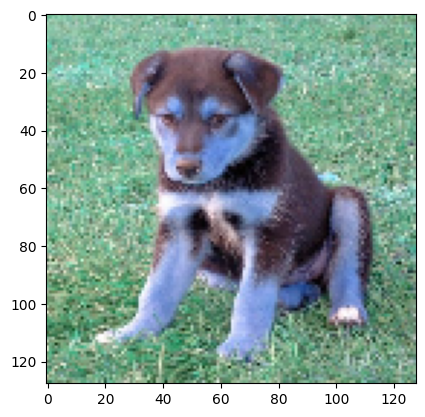

In [107]:
index = np.random.randint(0, len(features))
img = features[index]
img =img.reshape( (1, 128, 128,3))

feature_maps = model_testfull.predict(img)

img = tf.squeeze(img)
plt.imshow(img)

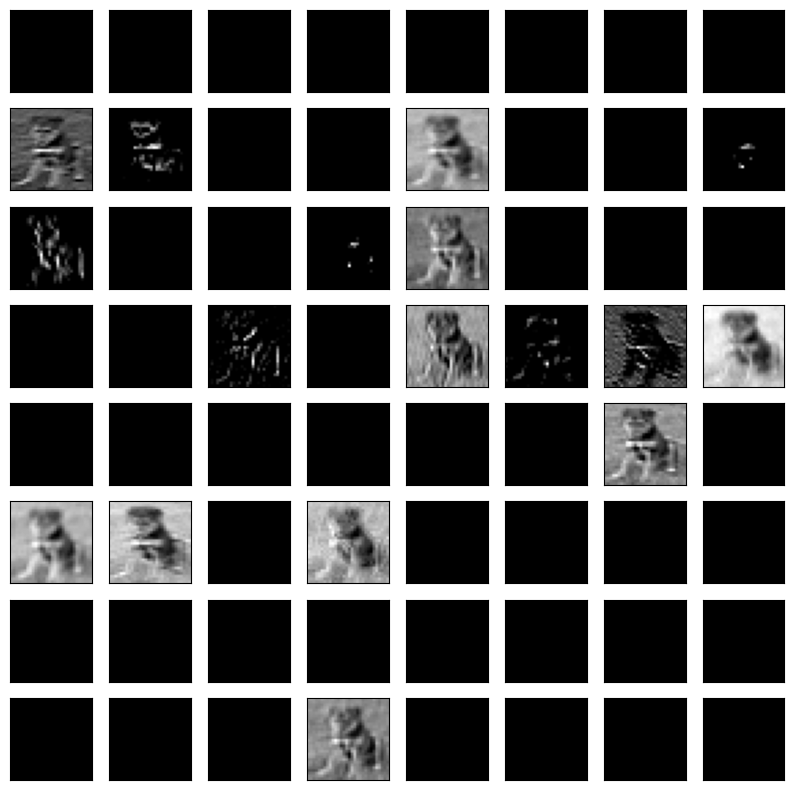

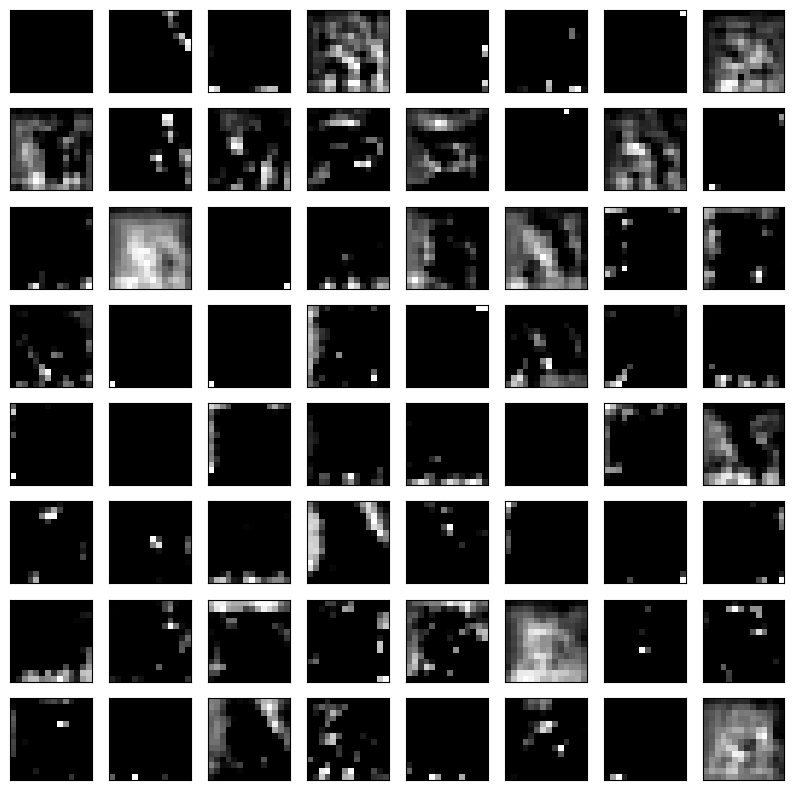

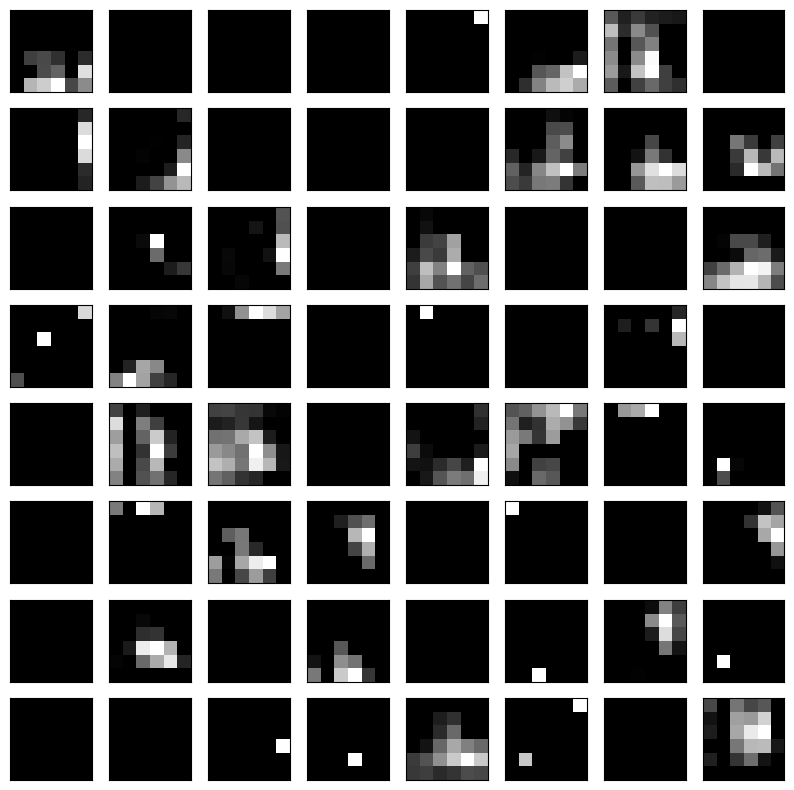

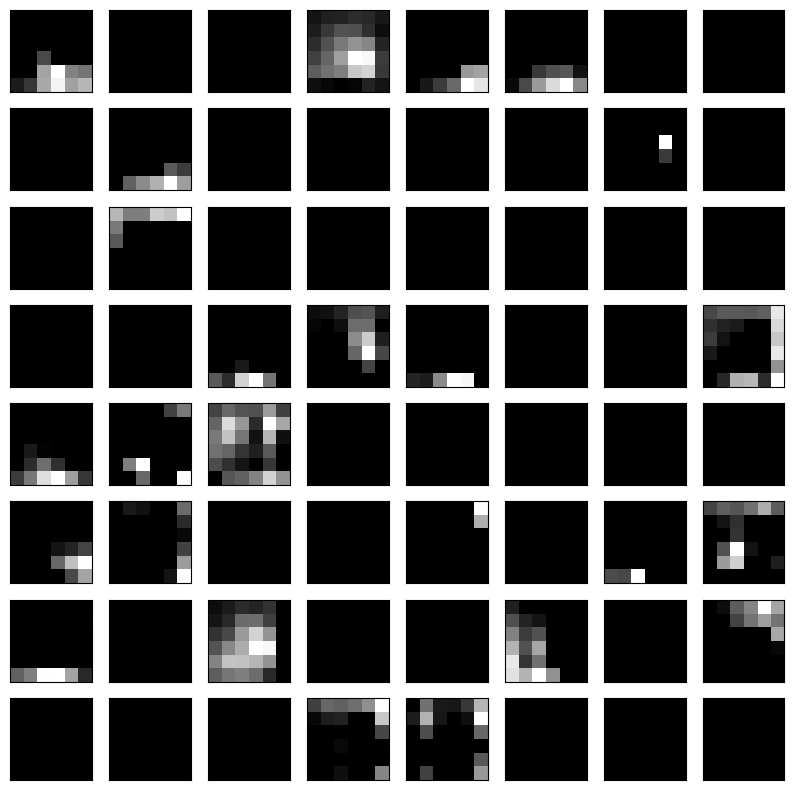

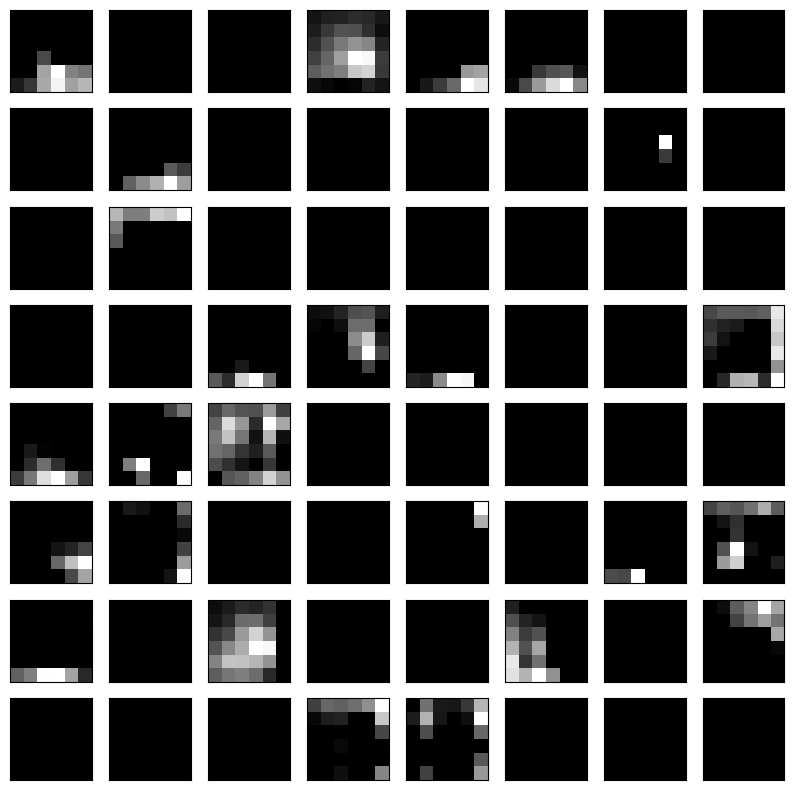

In [110]:
#as the layers go on, images/features get more and more abstracted so the model can better make a prediction
# some of the later layers don't change much possibly because the model already knows what it is

square = 8
for fmap in feature_maps:
	fig = plt.figure(figsize=(10, 10))
	ix = 1
	for i in range(square):
		for j in range(square):
			ax = plt.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	plt.show()

# Examples for slide

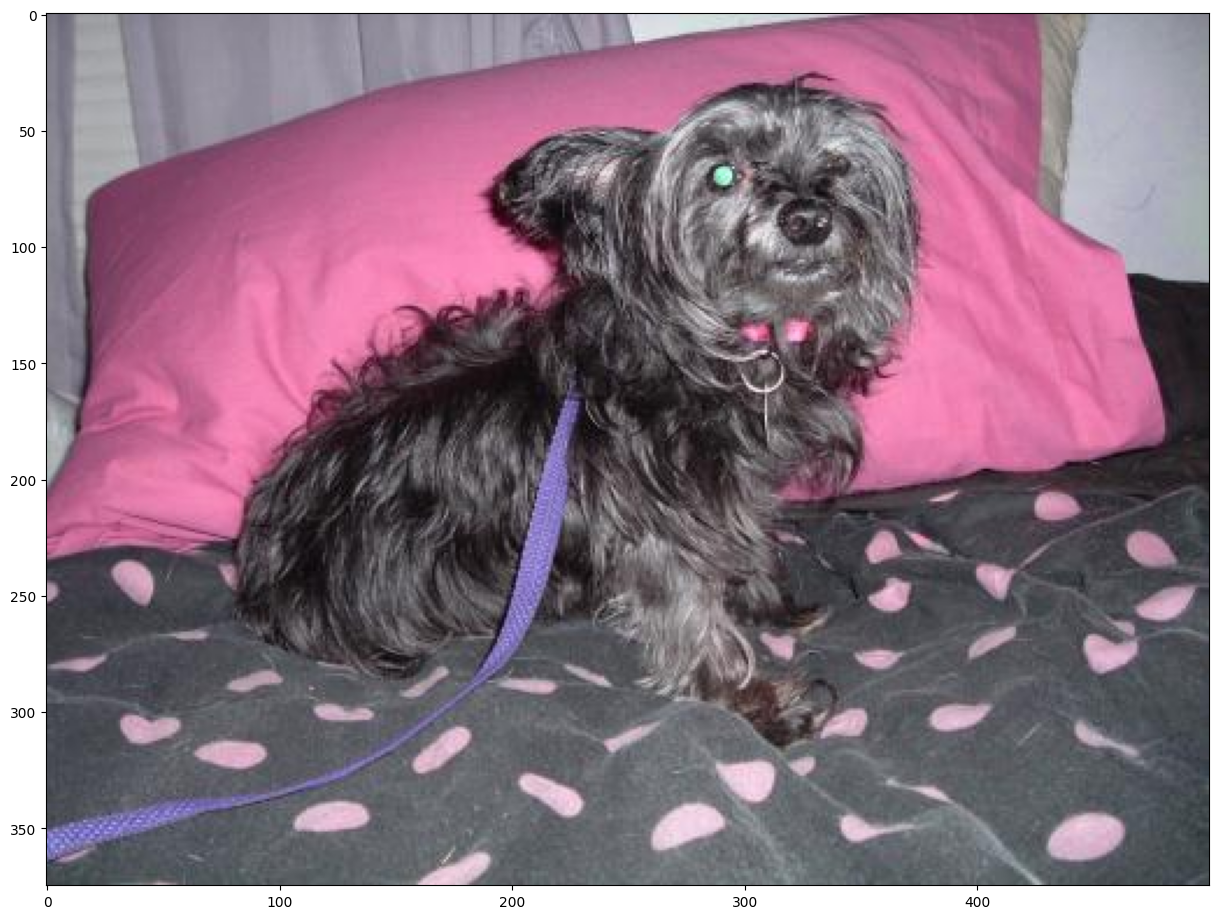

In [104]:
#before
plt.figure(figsize=(15,15))

sample = 0
filename = os.path.join(dog_folder, str(sample) + ".jpg") 
image = imread(filename)
plt.imshow(image)
    


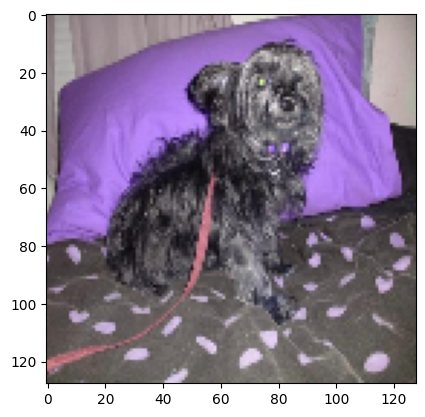

Label: 1.0


In [105]:
#after 

plt.show() 

sample = 12469

random_image = normalized[sample]
random_label = labels_array[sample]

plt.imshow(integer_image)
plt.show()

print('Label:', random_label)

156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step


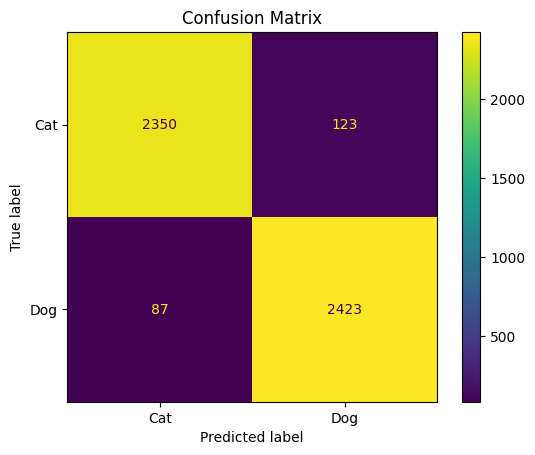

In [115]:
#confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

class_names = ["Cat", "Dog"]

predictions = model.predict(test_X)

predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot()

plt.title('Confusion Matrix')
plt.show()